In [9]:
## x轴为时间，y轴为GEX，每3分钟一张柱状图

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import time
import math


fileBasePath = "202410\\"
# 读取SPX数据
filename = fileBasePath + "QQQInterdayOIData.txt"
df1 = pd.read_csv(filename, sep=",")
df1.columns = ['Time', 'Symbol', 'Strike', 'ExpiredDay', 'Right', 'Volume', 'OI', 'GAMMA', 'Spot']

df1['Time'] = df1['Time'].astype(str).str.strip().str[4:14]
df1['Right'] = df1['Right'].astype(str).str.strip()
df1['Time'] = df1['Time'].str[:-2]
df1['Spot'] = df1['Spot'].astype(float)
df1['Volume'] = df1['Volume'].astype(float)
df1['OI'] = df1['OI'].astype(float)
df1['GAMMA'] = df1['GAMMA'].astype(float)

# GEX 换算成十亿单位
df1['CallGEX'] = np.where(df1['Right'] == 'C', (df1['GAMMA'])*(df1['OI'])*100*(df1['Spot'])*(df1['Spot'])*0.01/100**9, 0)
df1['PutGEX'] = np.where(df1['Right'] == 'P', -(df1['GAMMA'])*(df1['OI'])*100*(df1['Spot'])*(df1['Spot'])*0.01/100**9, 0)
df1['TotalGEX'] = df1['CallGEX'] + df1['PutGEX']
# 将 'Time' 转换为日期时间格式
df1['Time'] = pd.to_datetime(df1['Time'], format='%m%d%H%M')

# 设置时间间隔
time_interval = pd.Timedelta(minutes=10)

# 获取数据的起始时间和结束时间
start_time = df1['Time'].min()
end_time = df1['Time'].max()
start_time1 = df1['Time'].min()
end_time1 = df1['Time'].max()
start_time = max(start_time, start_time1)
end_time = min(end_time, end_time1)


# 手动设置起始时间
# # 提取年、月、日、时、分
now = datetime.now()
# current_month = now.month
# current_day = now.day
# current_hour = now.hour
# current_minute = now.minute
# 减去30分钟
time_minus_30 = end_time - timedelta(minutes=30)

start_time = pd.Timestamp(year=1900, month=time_minus_30.month, day=time_minus_30.day, hour=time_minus_30.hour, minute=time_minus_30.minute)

# 测试用
# start_time = pd.Timestamp(year=1900, month=7, day=29, hour=9, minute=30)
# end_time = pd.Timestamp(year=1900, month=7, day=29, hour=16, minute=30)

# 分割数据并绘制柱状图
current_time = start_time

1900-10-09 10:58:00
1900-10-09 11:08:00
1900-10-09 11:18:00
1900-10-09 11:28:00
1900-10-09 11:28:00


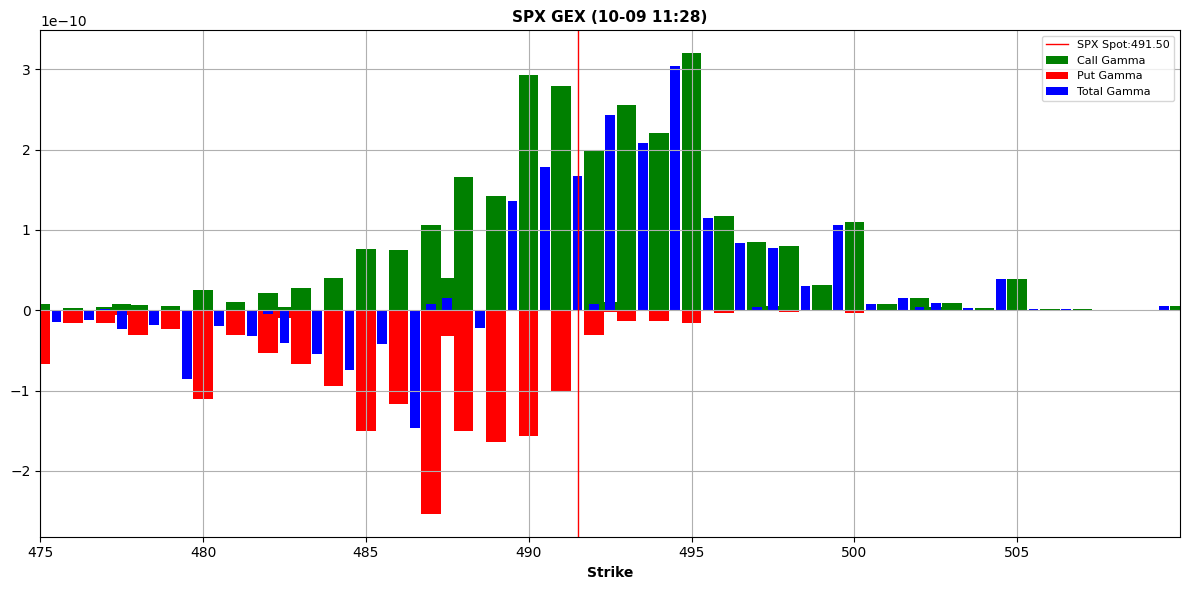

In [10]:
# 初始化变量用于存储上一个时间段的数据
prev_grouped_df = None
prev_grouped_df1 = None
prev_grouped_df2 = None
prev_time = None

while current_time <= end_time:
    print(current_time)
    # 获取当前时间段内的数据
    # mask = (df['Time'] >= current_time) & (df['Time'] < current_time + time_interval)
    
    # SPX
    mask1 = df1['Time'] == current_time
    current_df1 = df1.loc[mask1]    
    # print(current_df)
    # print(current_df1)
    # print(current_df2)
    # 如果当前时间段内有数据，则绘制柱状图
    if not current_df1.empty: 
      
      # spx
      spotPrice1 = current_df1['Spot'].iloc[0]
      fromStrike1= int(spotPrice1) - 15
      toStrike1= int(spotPrice1) + 15
      fromStrike1 = math.floor(fromStrike1/5)*5
      toStrike1 = math.ceil(toStrike1/5)*5
   
      grouped_df1 = current_df1.groupby('Strike')[['CallGEX', 'PutGEX', 'TotalGEX']].sum().reset_index()

      if not grouped_df1.empty: 
        # plt.figure(figsize=(5, 2.5))  # 设置图表大小 (宽度, 高度)
        fig, (ax2) = plt.subplots(1, 1,figsize=(12, 6))  # 设置图表大小 (宽度, 高度)
        # plt.grid()

        # 第二个子图
        # 设置 x 轴刻度，每隔 10 个刻度显示一个刻度
        # ax2.grid(True)
        # ax2.set_xlim(fromStrike1, toStrike1)
        # ax2.set_xticks(range(fromStrike1, toStrike1, 5))         
        
        # 绘制柱状图
        if prev_grouped_df1 is None and prev_time is None:
          print(current_time)
        # 这个是 put/call GEX 的和 
        # plt.bar(grouped_df['Strike'], gex_values, width=0.5, linewidth=0.1, edgecolor='k', label="Current GEX",color=['red' if gex < 0 else 'green' for gex in grouped_df['GEX']])
        ax2.bar(grouped_df1['Strike'], grouped_df1['CallGEX'], width=0.6, color='green', label="Call Gamma")
        ax2.bar(grouped_df1['Strike'], grouped_df1['PutGEX'], width=0.6, color='red', label="Put Gamma") 
        ax2.bar(grouped_df1['Strike']-0.5, grouped_df1['TotalGEX'], width=0.3, color='blue', label="Total Gamma") 
        # ax2.bar(grouped_df1['Strike']+1.1, grouped_df1['CallGEX'], width=0.3, color='green', label="Call OI Gamma")
        # ax2.bar(grouped_df1['Strike']+1.1, grouped_df1['PutGEX'], width=0.3, color='red', label="Put OI Gamma") 
        # 计算差值并绘制差值柱状图
        # if prev_grouped_df is not None and prev_time is not None and prev_grouped_df.shape[0] == grouped_df.shape[0]:
        if prev_grouped_df1 is not None and prev_time is not None:
            # print(current_time)

            # 合并当前数据框和前一个数据框，以确保行数相同
            merged_df = pd.merge(grouped_df1, prev_grouped_df1, on='Strike', how='outer', suffixes=('_current', '_prev'))
            # 填充缺失值为0
            merged_df.fillna(0, inplace=True)
            if current_time == pd.Timestamp('1900-06-21 14:24:00'):
              delta = merged_df[merged_df['Strike'] == 482]
              print(delta)

            ax2.bar(merged_df['Strike'], (merged_df['CallGEX_current'] - merged_df['CallGEX_prev']), width=0.8, color='green', label="D-CallGamma")
            ax2.bar(merged_df['Strike'], (merged_df['PutGEX_current'] - merged_df['PutGEX_prev']), width=0.8, color='red', label="D-PutGamma")             
            # prev_gex_values = prev_grouped_df['GEX']
            # delta_gex_values = gex_values - prev_gex_values
            # plt.bar(grouped_df['Strike'], delta_gex_values, width=0.5, linewidth=0.1, edgecolor='k', label="Delta GEX", color='orange')
        
        ax2.grid(True)
        ax2.set_xlim(fromStrike1, toStrike1)
        ax2.set_xticks(range(fromStrike1, toStrike1, 5))
        ax2.set_title(f'SPX GEX ({current_time.strftime("%m-%d %H:%M")})', fontweight="bold", fontsize=11)
        ax2.set_xlabel('Strike', fontweight="bold")
        # ax2.set_ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
        ax2.axvline(x=spotPrice1, color='r', lw=1, label="SPX Spot:" + str("{:,.2f}".format(spotPrice1)))
        ax2.legend(fontsize=8)          

        plt.tight_layout()
        plt.show()
      # 更新上一个时间段的数据
      prev_grouped_df1 = grouped_df1  
      prev_time = current_time

    # 更新当前时间
    current_time += time_interval